## Potential Energy Metrics

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import PE_module

In [21]:
import importlib
importlib.reload(PE_module)

<module 'PE_module' from '/home/jovyan/mesoscale_buoyancy_param_ML/offline_analysis/energetics/PE_module.py'>

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
import gcsfs
fs = gcsfs.GCSFileSystem()
#fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/')

In [5]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr')

In [6]:
## Some data mods needed for convenience
ds = ds.isel(Time=slice(-25,None))
# To work with APE, instead of PE
ds['e'] = ds.e - ds.e.isel(Time=0).mean(['xh','yh'])

# There is a repeated value in the way MOM6 outputs data, this is being removed here.
ds = ds.isel(xq=slice(1,None), yq=slice(1,None))

In [8]:
ds['div_uh'], ds['uh'], ds['vh']  = PE_module.div_uh(ds)
ds['PE'], ds['PEi'] = PE_module.PE(ds)
ds['dt_eta'] = PE_module.eta_tend(ds) 
ds['PE_tend'], ds['PEi_tend']= PE_module.PE_tend(ds)

In [9]:
Lscales = [50e3,100e3,200e3,400e3]

ds_filt_dic = {}

for L in Lscales:
    ds_filt = PE_module.filter_dataset(ds, L)
    print(L)
    ds_filt.load();

    ds_filt['MPE'], ds_filt['MPEi'] = PE_module.PE(ds_filt)
    ds_filt['EPE'] = ds['PE'] - ds_filt['MPE']
    ds_filt['EPEi'] = ds['PEi'] - ds_filt['MPEi']
    
    ds_filt['dt_eta'] = PE_module.eta_tend(ds_filt, var='div_uhbar')
    ds_filt['dt_eta_mean_by_mean'] = PE_module.eta_tend(ds_filt, var='div_ubarhbar')
    ds_filt['dt_eta_mean_by_eddy'] = PE_module.eta_tend(ds_filt, var='div_uphp')
    
    ds_filt['MPE_tend_mean'], ds_filt['MPEi_tend_mean'] = PE_module.PE_tend(ds_filt, var='dt_eta_mean_by_mean')
    ds_filt['MPE_tend_eddy'], ds_filt['MPEi_tend_eddy'] = PE_module.PE_tend(ds_filt, var='dt_eta_mean_by_eddy')
    
    ds_filt['MPE_tend_mean_spectral'],ds_filt['MPEi_tend_mean_spectral'] = PE_module.PE_tend_spectral(ds_filt, var='dt_eta_mean_by_mean')
    ds_filt['MPE_tend_eddy_spectral'],ds_filt['MPEi_tend_eddy_spectral'] = PE_module.PE_tend_spectral(ds_filt, var='dt_eta_mean_by_eddy')

    ds_filt_dic[str(L/1e3)] = ds_filt

50000.0
100000.0
200000.0
400000.0


In [10]:
dx = 4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


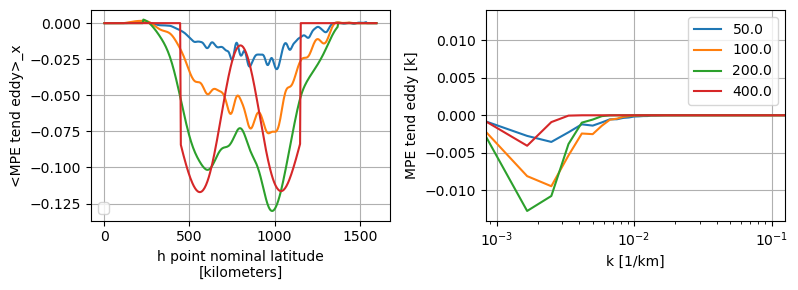

In [11]:
plt.figure(figsize=(8,3))

plt.subplot(121)
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['MPE_tend_eddy'] * dx).sum(['xh']).mean(['Time']).plot()
#plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
#plt.xscale('log')
plt.grid()
plt.legend()
plt.ylabel('<MPE tend eddy>_x')

plt.subplot(122)
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['MPE_tend_eddy_spectral'] * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot(label=str(L/1e3))
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


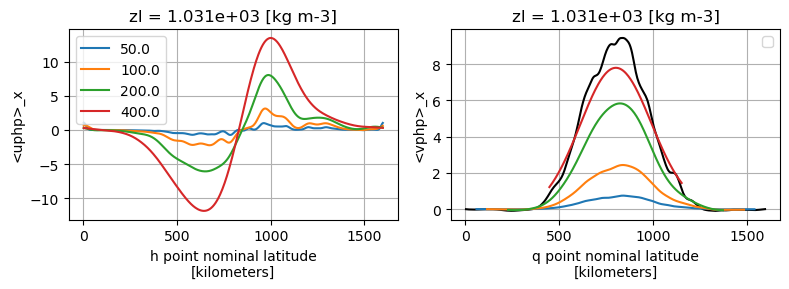

In [12]:
plt.figure(figsize=(8,3))

plt.subplot(121)
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['uphp'] ).isel(zl=0).mean(['xq']).mean(['Time']).plot(label=str(L/1e3))
#plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
#plt.xscale('log')
plt.grid()
plt.legend()
plt.ylabel('<uphp>_x')

plt.subplot(122)
ds.vh.isel(zl=0).mean(['xh']).mean(['Time']).plot(color='k')
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['vphp'] ).isel(zl=0).mean(['xh']).mean(['Time']).plot()
#plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
#plt.xscale('log')
plt.grid()
plt.legend()
plt.ylabel('<vphp>_x')

plt.tight_layout()

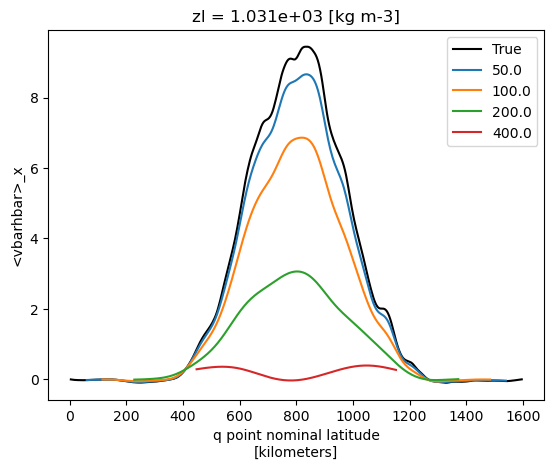

In [13]:
ds.vh.isel(zl=0).mean(['xh']).mean(['Time']).plot(color='k', label='True')
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['vbarhbar'] ).isel(zl=0).mean(['xh']).mean(['Time']).plot(label=str(L/1e3))
plt.ylabel('<vbarhbar>_x')
plt.legend()

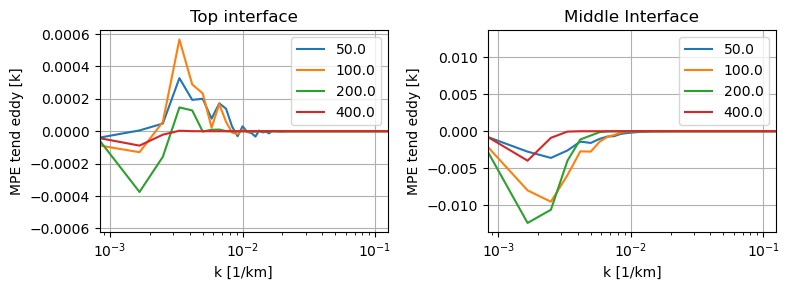

In [32]:
plt.figure(figsize=(8,3)) 

plt.subplot(121)
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['MPEi_tend_eddy_spectral'].real * ds_filt.freq_xh).isel(zi=0).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot(label=str(L/1e3))
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')
plt.title('Top interface')

plt.subplot(122)
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['MPEi_tend_eddy_spectral'].real * ds_filt.freq_xh).isel(zi=1).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot(label=str(L/1e3))
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')
plt.title('Middle Interface')

plt.tight_layout()

Almost all of the contribution comes from middle interface. 

Text(0.5, 1.0, 'Middle Interface')

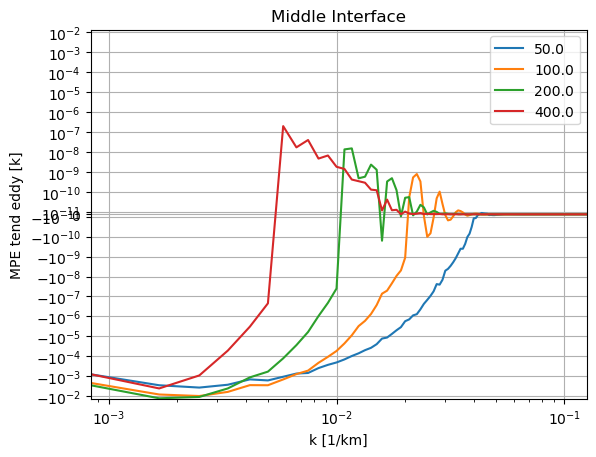

In [33]:
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (ds_filt['MPEi_tend_eddy_spectral'].real * ds_filt.freq_xh).isel(zi=1).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot(label=str(L/1e3))
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.yscale('symlog', linthresh=1e-10)
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')
plt.title('Middle Interface')


Text(0, 0.5, 'MPE tend eddy [k]')

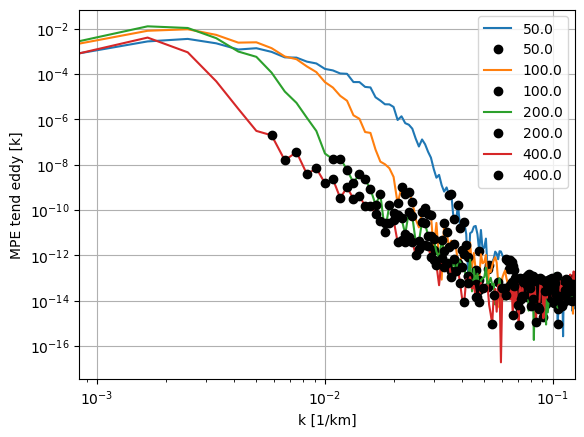

In [42]:
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (np.abs( (ds_filt['MPE_tend_eddy_spectral'].real * ds_filt.freq_xh ).sel(yh=slice(400, 1200)).mean(['Time','yh']) ) ).plot(label=str(L/1e3))
    ((ds_filt['MPE_tend_eddy_spectral'].real) * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot.line("ko", label=str(L/1e3))
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')

Text(0, 0.5, 'MPE tend eddy [k]')

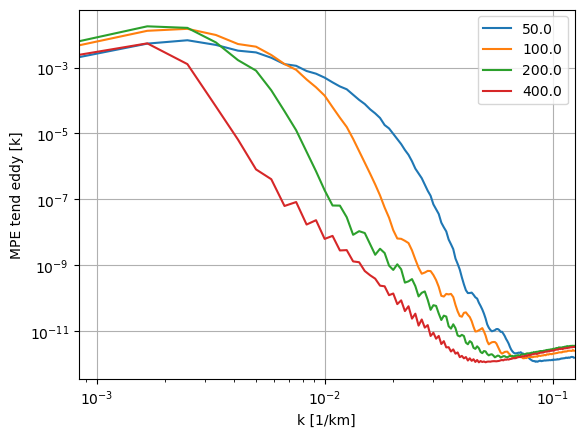

In [71]:
for L in Lscales:
    ds_filt = ds_filt_dic[str(L/1e3)]
    (np.abs(ds_filt['MPE_tend_eddy_spectral']) * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot(label=str(L/1e3))
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')

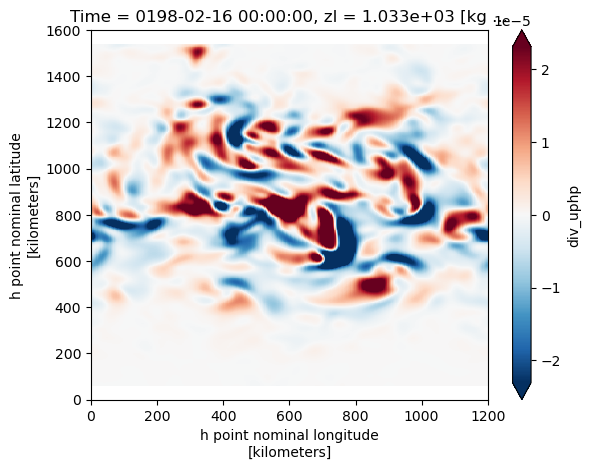

In [50]:
ds_filt_dic['50.0'].div_uphp.isel(Time=-1, zl=1).plot(robust=True)

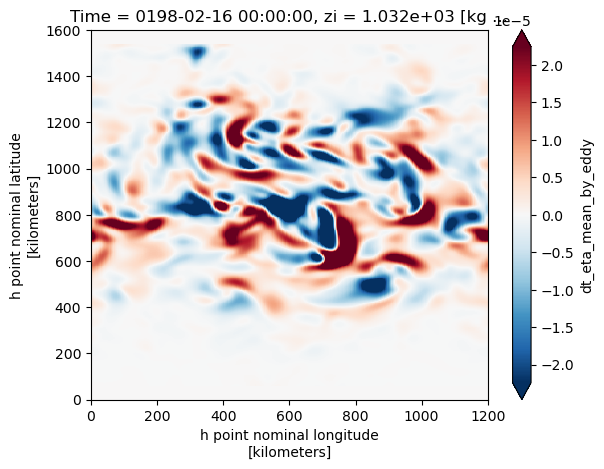

In [52]:
ds_filt_dic['50.0']['dt_eta_mean_by_eddy'].isel(Time=-1, zi=1).plot(robust=True)

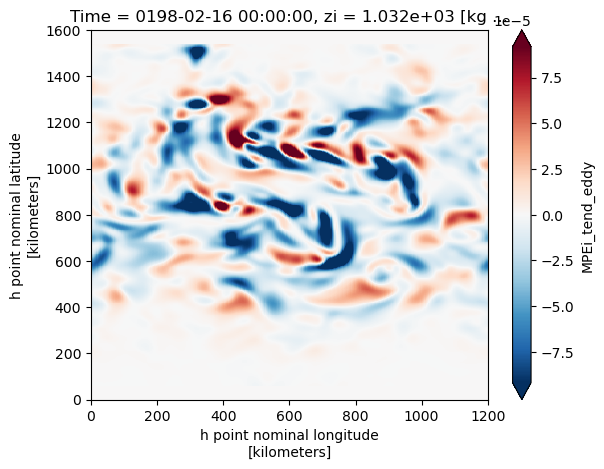

In [55]:
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(Time=-1, zi=1).plot(robust=True)


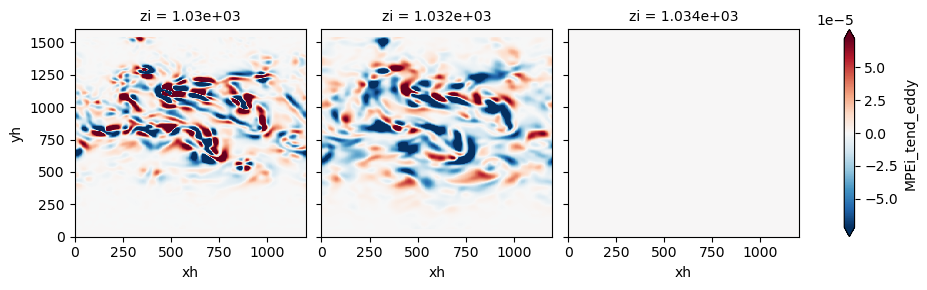

In [57]:
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(Time=-1).plot(col='zi', robust=True)


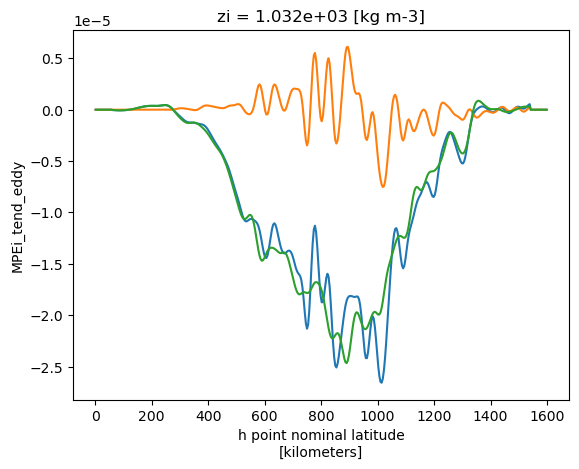

In [63]:
ds_filt_dic['50.0']['MPE_tend_eddy'].mean('Time').mean('xh').plot()
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(zi=0).mean('Time').mean('xh').plot()
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(zi=1).mean('Time').mean('xh').plot()

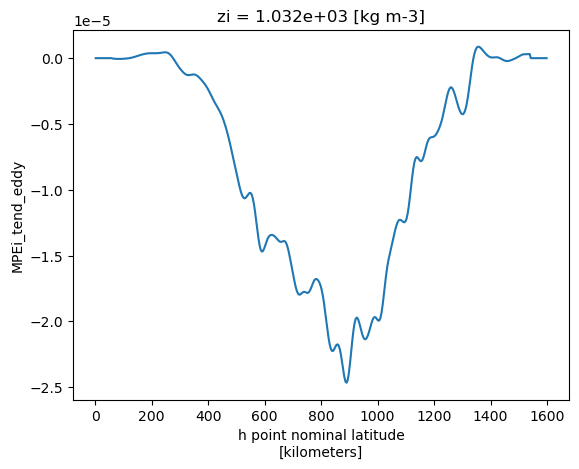

In [65]:
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(zi=1).mean('Time').mean('xh').plot()

In [67]:
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(zi=1).mean('Time').mean('xh').values[10:20]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.77835682e-08, -3.68685233e-08, -4.52145317e-08,
       -5.19175818e-08, -5.65215997e-08])

In [ ]:
ds_filt_dic['50.0']['MPEi_tend_eddy'].isel(zi=1.mean('Time').mean('xh').plot()

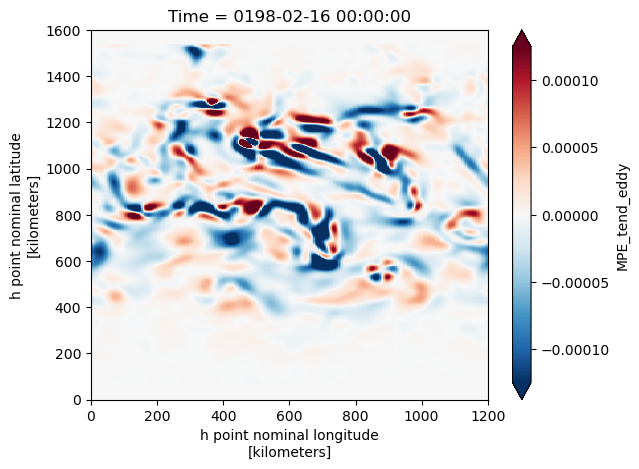

In [56]:
ds_filt_dic['50.0']['MPE_tend_eddy'].isel(Time=-1).plot(robust=True)


## Scratch figures

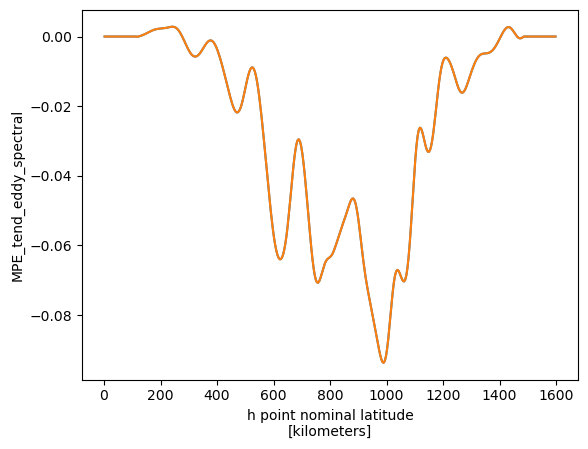

In [18]:
# Parseval's for cross spectra.
# Ensure that the true amplitude and true phase options are on. 
dx = 4
(ds_filt['MPE_tend_eddy'] * dx).sum(['xh']).mean(['Time']).plot()
(ds_filt['MPE_tend_eddy_spectral']* ds_filt.freq_xh.spacing ).sum(['freq_xh']).mean(['Time']).plot()

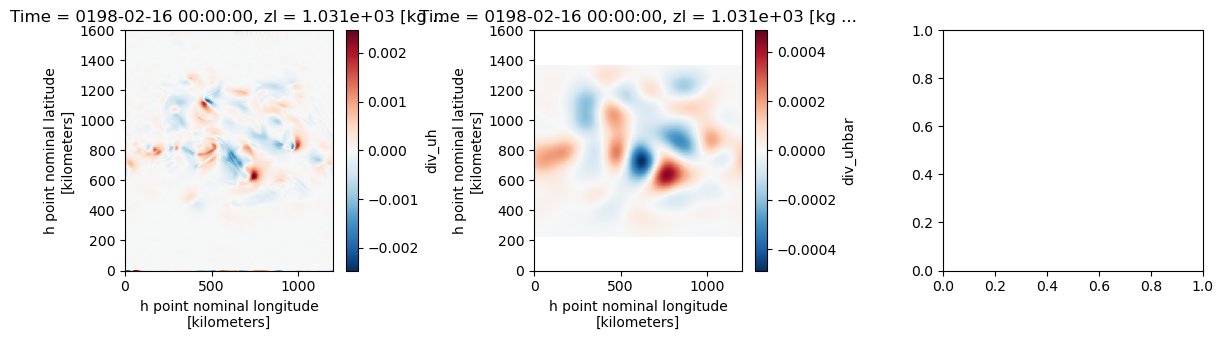

In [12]:
plt.figure(figsize=(12,3.5))

plt.subplot(131)
ds.div_uh.isel(Time=-1, zl=0).plot()

plt.subplot(132)
ds_filt.div_uhbar.isel(Time=-1, zl=0).plot()

plt.subplot(133)
#(ds - ds_filt).div_uh.isel(Time=-1, zl=0).plot()

plt.tight_layout()

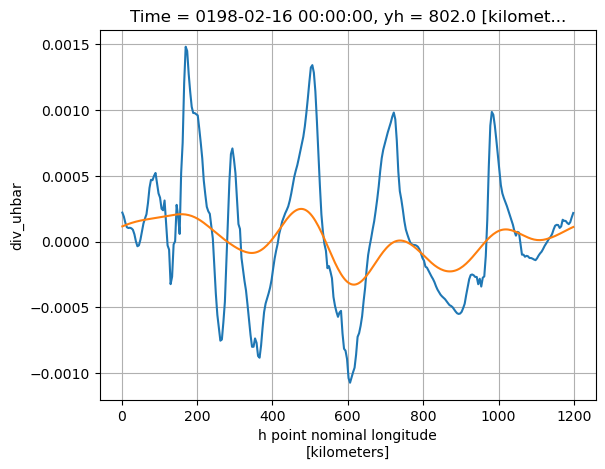

In [13]:
ds.div_uh.isel(Time=-1, zl=0, yh=200).plot()
ds_filt.div_uhbar.isel(Time=-1, zl=0, yh=200).plot()
plt.grid()

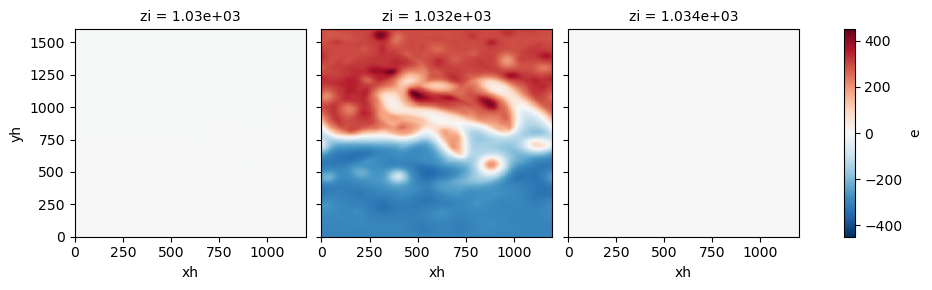

In [18]:
ds.e.isel(Time=-1).plot(col='zi')

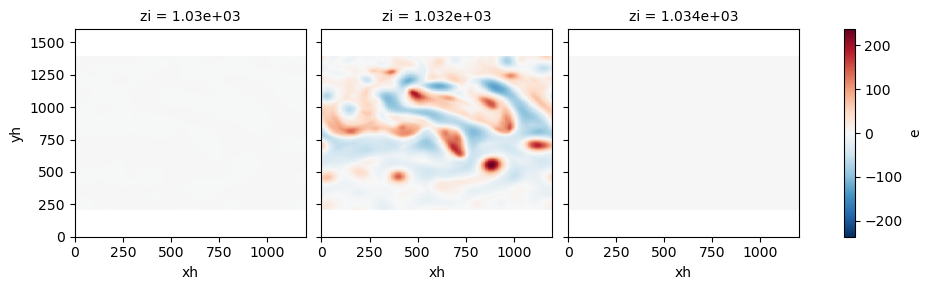

In [19]:
(ds-ds_filt).where(ds_filt.filt_mask>0).e.isel(Time=-1).plot(col='zi')

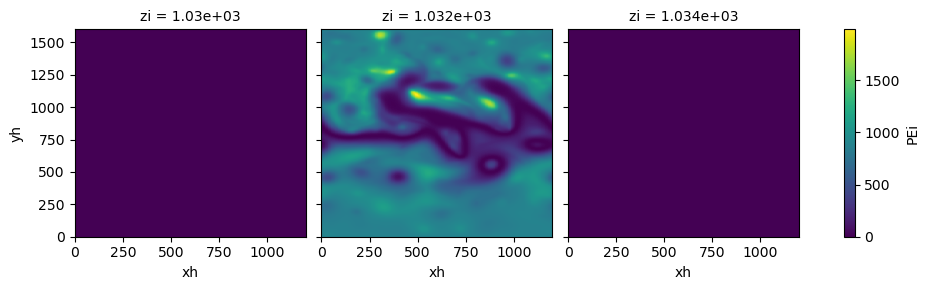

In [20]:
ds.PEi.isel(Time=-1).plot(col='zi')

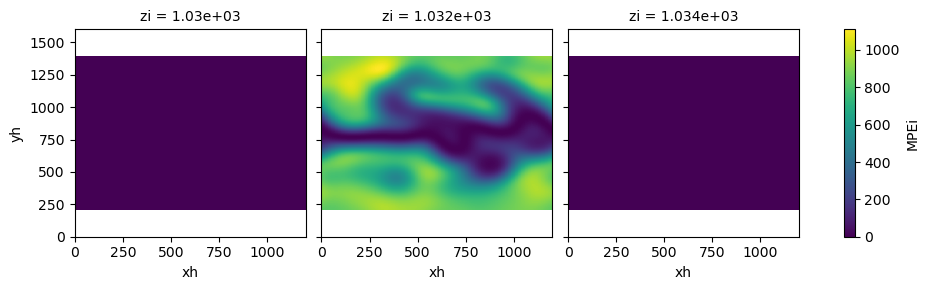

In [21]:
ds_filt.MPEi.where(ds_filt.filt_mask>0).isel(Time=-1).plot(col='zi')

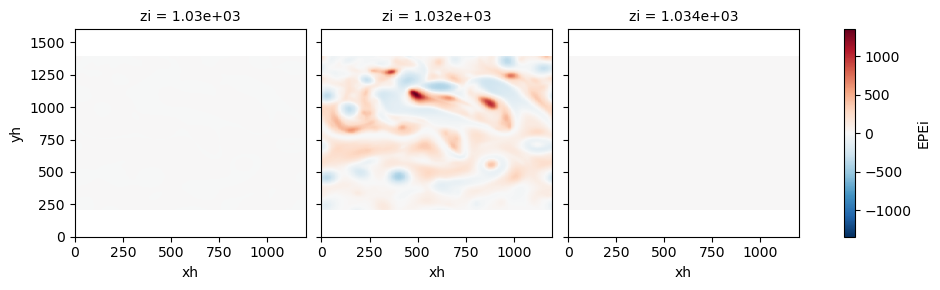

In [22]:
ds_filt.EPEi.where(ds_filt.filt_mask>0).isel(Time=-1).plot(col='zi')

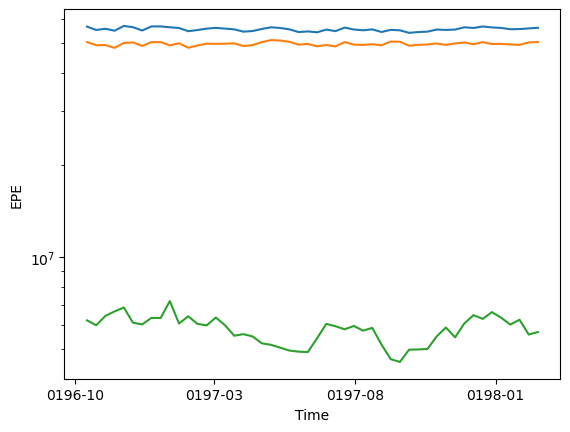

In [23]:
ds.PE.where(ds_filt.filt_mask>0).sum(['xh', 'yh']).plot()
ds_filt.MPE.where(ds_filt.filt_mask>0).sum(['xh', 'yh']).plot()
ds_filt.EPE.where(ds_filt.filt_mask>0).sum(['xh', 'yh']).plot()
plt.yscale('log')

## Spectral 

In [35]:
import xrft

In [59]:
ds

<xarray.Dataset>
Dimensions:   (Time: 50, zl: 2, yq: 400, xq: 300, zi: 3, yh: 400, xh: 300)
Coordinates:
  * Time      (Time) object 0196-10-14 00:00:00 ... 0198-02-16 00:00:00
  * xh        (xh) float64 2.0 6.0 10.0 14.0 ... 1.19e+03 1.194e+03 1.198e+03
  * xq        (xq) float64 4.0 8.0 12.0 16.0 ... 1.192e+03 1.196e+03 1.2e+03
  * yh        (yh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq        (yq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * zi        (zi) float64 1.03e+03 1.032e+03 1.034e+03
  * zl        (zl) float64 1.031e+03 1.033e+03
Data variables: (12/13)
    PV        (Time, zl, yq, xq) float32 dask.array<chunksize=(50, 2, 400, 300), meta=np.ndarray>
    RV        (Time, zl, yq, xq) float32 dask.array<chunksize=(50, 2, 400, 300), meta=np.ndarray>
    e         (Time, zi, yh, xh) float32 dask.array<chunksize=(50, 3, 400, 300), meta=np.ndarray>
    h         (Time, zl, yh, xh) float64 dask.array<chunksize=(50, 2, 400, 300), meta=np.ndarray>
    u         (Time, zl, yh, xq) float32 dask.array<chunksize=(50, 2, 400, 300), meta=np.ndarray>
    v         (Time, zl, yq, xh) float32 dask.array<chunksize=(50, 2, 400, 300), meta=np.ndarray>
    ...        ...
    gr        (zi) float64 9.81 0.01962 0.0
    PE        (Time, yh, xh) float64 dask.array<chunksize=(50, 400, 300), meta=np.ndarray>
    PEi       (zi, Time, yh, xh) float64 dask.array<chunksize=(3, 50, 400, 300), meta=np.ndarray>
    dt_eta    (Time, zi, yh, xh) float32 0.0004709 0.0005477 ... 0.0 0.0
    PE_tend   (Time, yh, xh) float64 dask.array<chunksize=(50, 400, 300), meta=np.ndarray>
    PEi_tend  (zi, Time, yh, xh) float64 dask.array<chunksize=(3, 50, 400, 300), meta=np.ndarray>
Attributes:
    filename:   prog__00010.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      Phillips experiment

In [60]:
eta = ds.e.isel( zi=1)
duh = ds.div_uh.isel(zl=1)

da_dft = xrft.dft(eta, dim='xh', true_phase=True, true_amplitude=True)
dx = ds.xh[1] - ds.xh[0]
real_space = (eta**2 * dx).sum('xh')
fourier_space = np.abs(da_dft * da_dft.conj() * da_dft.freq_xh.spacing ).sum('freq_xh')

da_duh_dft = xrft.dft(duh, dim='xh', true_phase=True, true_amplitude=True)

real_space_eta_duh = (eta*duh*dx).sum('xh')
fourier_space_eta_duh = ((da_dft * np.conjugate(da_duh_dft)).real * da_dft.freq_xh.spacing).sum('freq_xh')

In [63]:
dx

<xarray.DataArray 'xh' ()>
array(4.)

In [45]:
power_spectrum = xrft.power_spectrum(eta, dim='xh')

In [48]:
PS_e_sum = power_spectrum.sum('freq_xh')

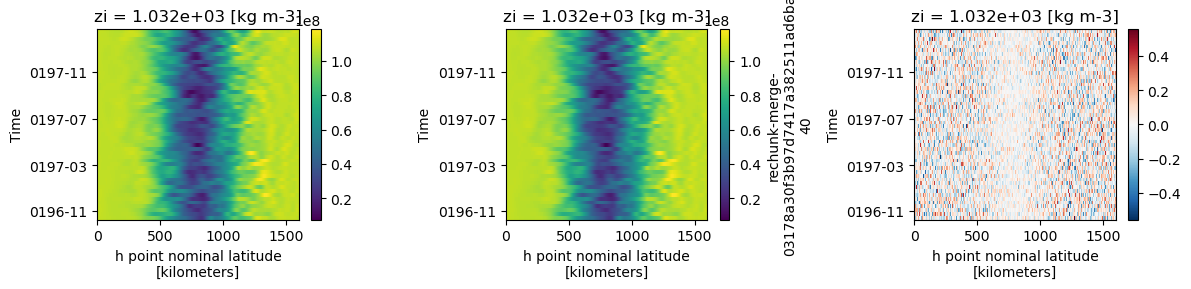

In [52]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
real_space.plot()

plt.subplot(132)
#fourier_space.plot()
PS_e_sum.plot()

plt.subplot(133)

#(real_space - fourier_space).plot()
(real_space - PS_e_sum).plot()

plt.tight_layout()

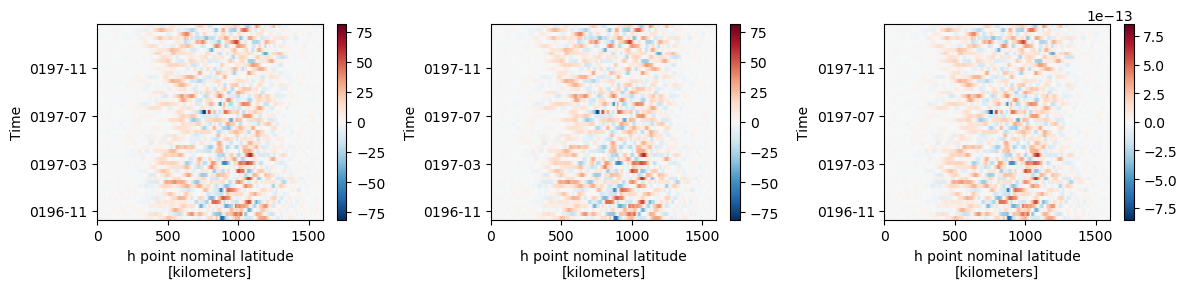

In [62]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
real_space_eta_duh.plot()
plt.title('')

plt.subplot(132)
fourier_space_eta_duh.plot()
plt.title('')


plt.subplot(133)

(real_space_eta_duh - fourier_space_eta_duh).plot()
plt.title('')

plt.tight_layout()

In [27]:
PS_e = xrft.power_spectrum(ds.e.where(ds_filt.filt_mask>0).isel(zi=1), dim='xh')
PS_efilt = xrft.power_spectrum(ds_filt.e.where(ds_filt.filt_mask>0).isel(zi=1), dim='xh')
PS_epfilt = xrft.power_spectrum( (ds - ds_filt).e.where(ds_filt.filt_mask>0).isel(zi=1), dim='xh')

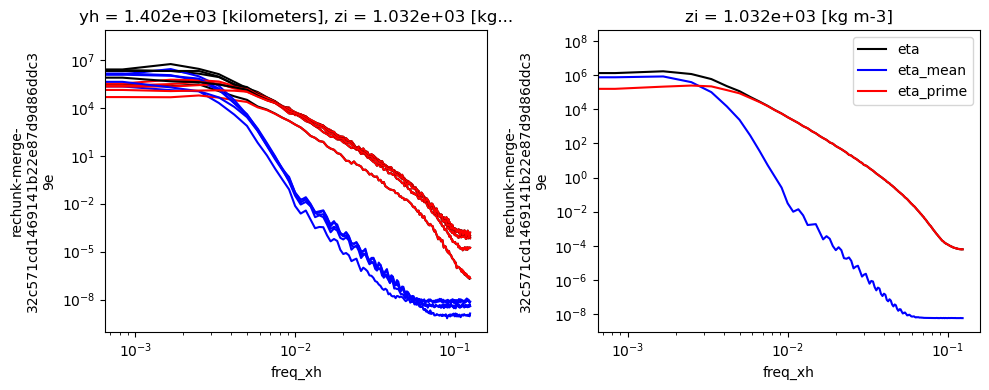

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
for i in [100, 150, 200, 250, 300, 350]:
    PS_e.mean('Time').isel(yh=i).plot(color='k')

    PS_efilt.mean('Time').isel(yh=i).plot(color='b')

    PS_epfilt.mean('Time').isel(yh=i).plot(color='r')
#PS_e.mean('Time').isel(yh=200).plot()
#PS_e.mean('Time').isel(yh=300).plot()

plt.yscale('log')
plt.xscale('log')

plt.subplot(122)
PS_e.mean('Time').mean('yh').plot(color='k', label='eta')
PS_efilt.mean('Time').mean('yh').plot(color='b', label='eta_mean')
PS_epfilt.mean('Time').mean('yh').plot(color='r', label='eta_prime')
plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.tight_layout()

## Tendencies

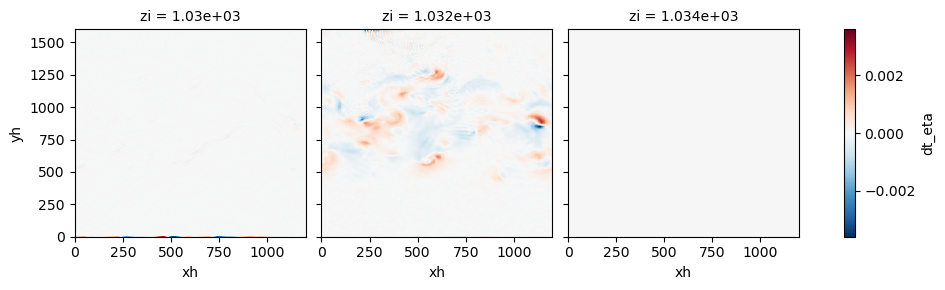

In [32]:
ds.dt_eta.isel(Time=0).plot(col='zi')

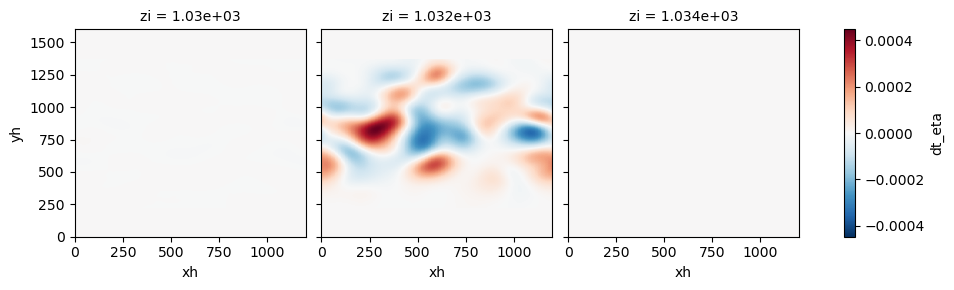

In [33]:
ds_filt.dt_eta.isel(Time=0).plot(col='zi')

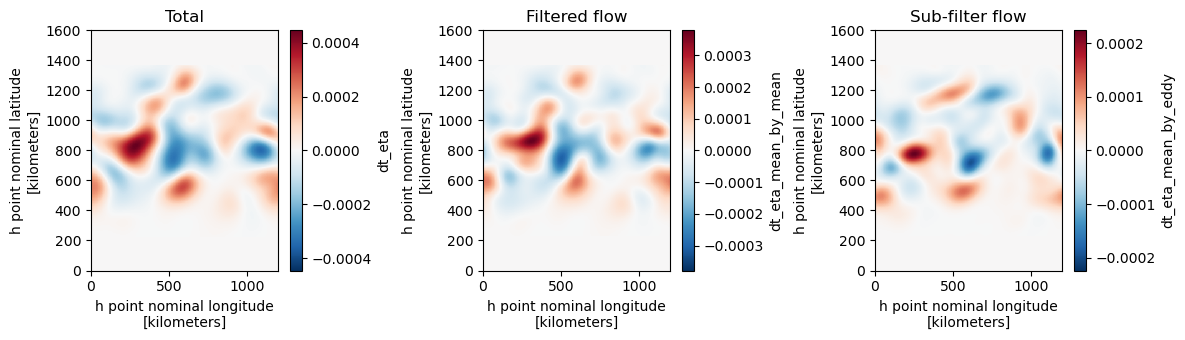

In [34]:
plt.figure(figsize=(12, 3.5))

plt.subplot(131)
ds_filt.dt_eta.isel(Time=0, zi=1).plot()
plt.title('Total')

plt.subplot(132)
ds_filt.dt_eta_mean_by_mean.isel(Time=0, zi=1).plot()
plt.title('Filtered flow')

plt.subplot(133)
ds_filt.dt_eta_mean_by_eddy.isel(Time=0, zi=1).plot()
plt.title('Sub-filter flow')

plt.tight_layout()

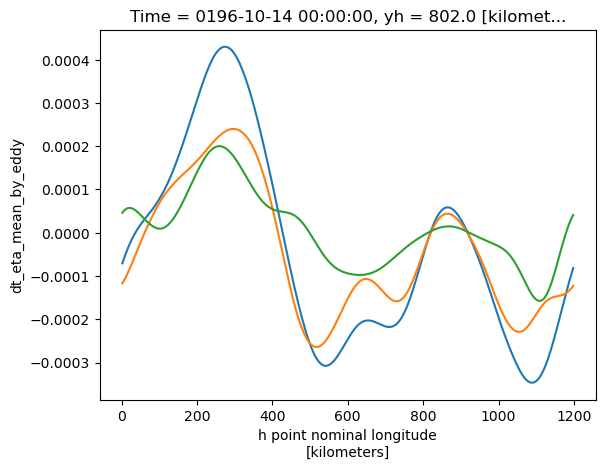

In [35]:
ds_filt.dt_eta.isel(Time=0, zi=1, yh=200).plot()
ds_filt.dt_eta_mean_by_mean.isel(Time=0, zi=1, yh=200).plot()
ds_filt.dt_eta_mean_by_eddy.isel(Time=0, zi=1, yh=200).plot()

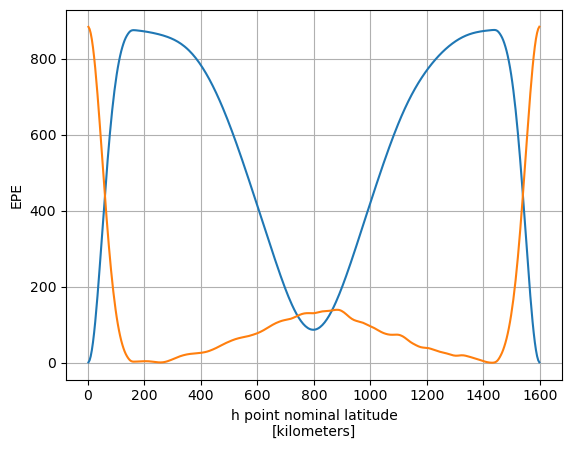

In [39]:
ds_filt.MPE.mean(['xh','Time']).plot()
ds_filt.EPE.mean(['xh','Time']).plot()
plt.grid()

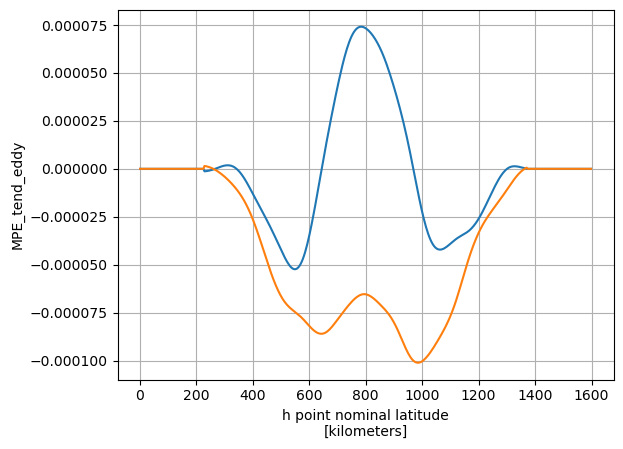

In [40]:
ds_filt.MPE_tend_mean.mean(['xh','Time']).plot()
ds_filt.MPE_tend_eddy.mean(['xh','Time']).plot()
plt.grid()

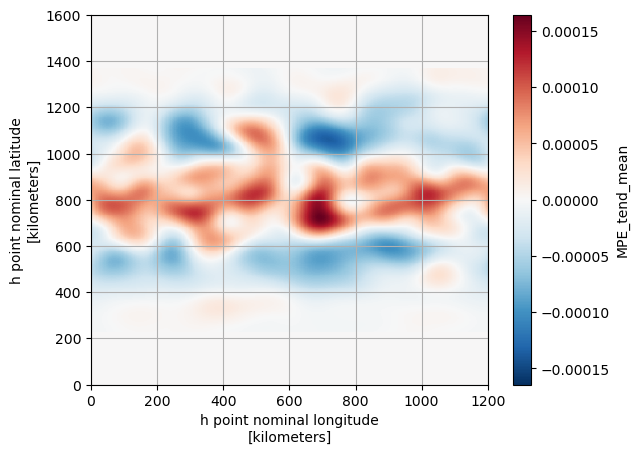

In [41]:
ds_filt.MPE_tend_mean.mean(['Time']).plot()
plt.grid()

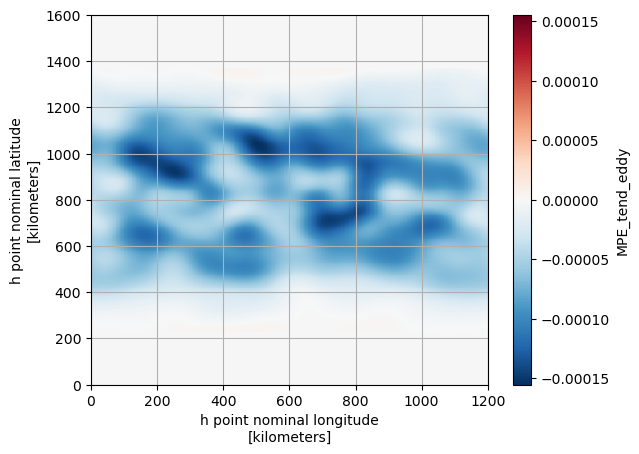

In [42]:
ds_filt.MPE_tend_eddy.mean(['Time']).plot()
plt.grid()

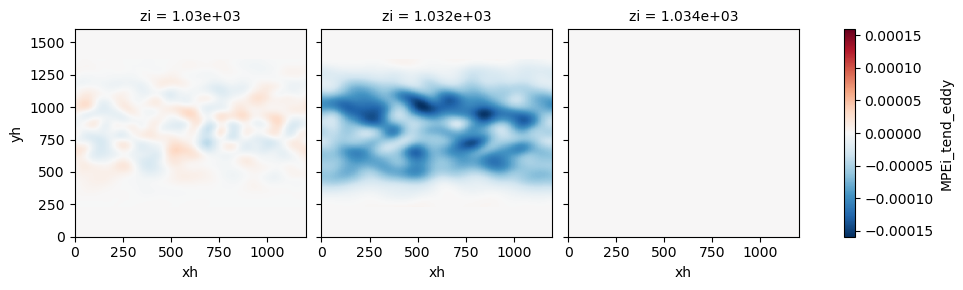

In [43]:
ds_filt.MPEi_tend_eddy.mean('Time').plot(col='zi')

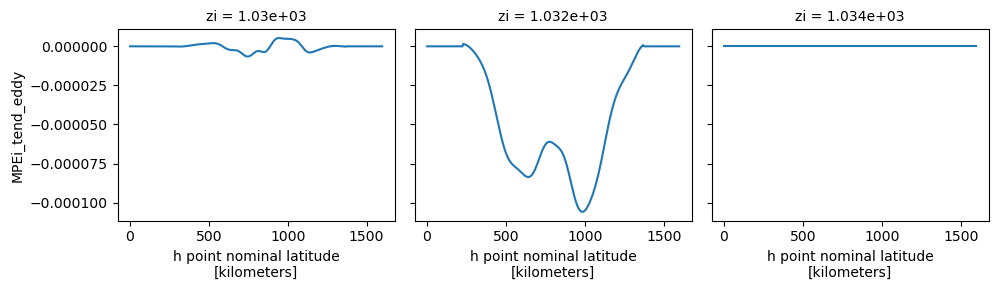

In [44]:
ds_filt.MPEi_tend_eddy.mean(['Time','xh']).plot(col='zi')

In [46]:
temp,_ = PE_tend_spectral(ds_filt, var='dt_eta_mean_by_eddy')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


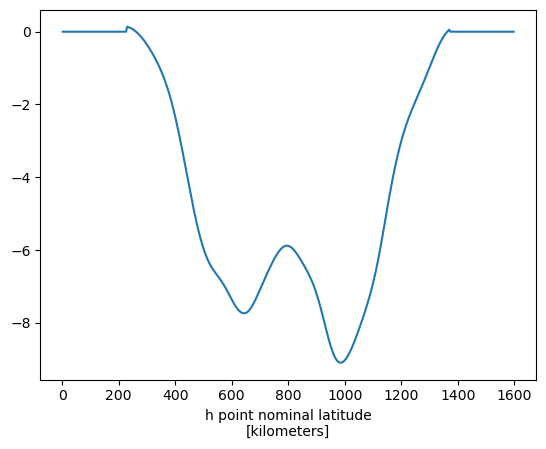

In [47]:
temp.sum('freq_xh').mean(['Time']).plot()

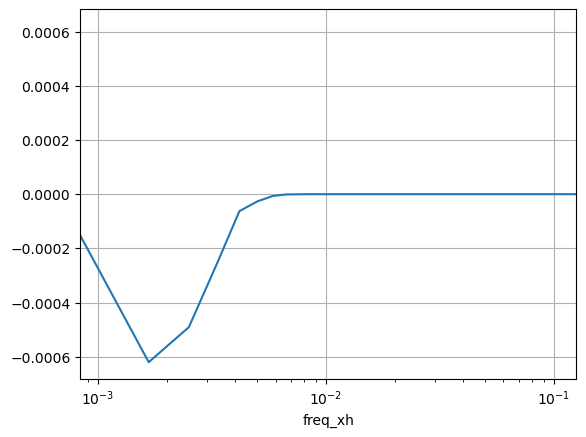

In [48]:
(temp.freq_xh * temp.sel(yh=slice(250, 1250))).mean(['Time','yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()

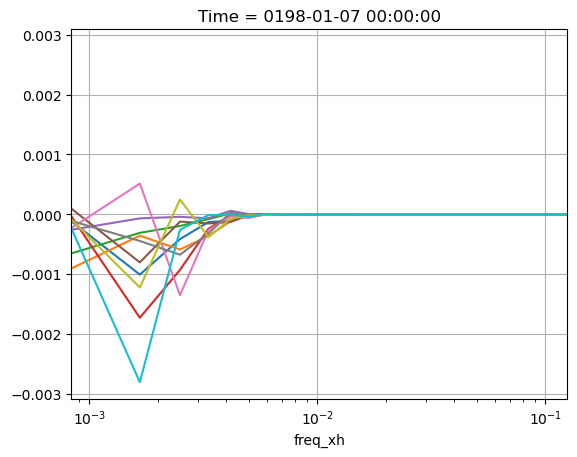

In [49]:
for i in range(0, 50, 5):
    (temp.freq_xh * temp.sel(yh=slice(250, 1250))).isel(Time=i).mean(['yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()